# Py - RTTOV

[PDF Python Interface Guide - NWP/SAF](https://nwp-saf.eumetsat.int/site/download/documentation/rtm/docs_rttov12/rttov-wrapper.pdf)



In [1]:
# System information
import pyrttov
import numpy as np
import os, sys, glob
import xarray
print(sys.executable)
print(sys.version_info)
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

ImportError: No module named pyrttov

In [2]:
def ef(p, t=None, over_water=True, over_ice=False, **kwargs):
    """
    from
    Sugidachi, T. and Fujiwara, M.: Correction of the Stepwise Change Observed at 0C in
    Meisei RS2-91, RS-01G, and RS-06G Radiosonde Relative Humidity Profiles,
    Journal of the Meteorological Society of Japan. Ser. II, 91(3), 323-336,
    doi:10.2151/jmsj.2013-306, 2013.

    Args:
        t: air temperature K
        p: air pressure Pa

    Returns:
        f : enhancement factor for saturation water vapor pressure
            depending on air temperature and air pressure
    """
    # Vaisala / Buck 1981  / WMO 2008
    # 1.0016 + 3.15e-6*p - 0.074 / p  # kPa
    if over_water:
        return 1.0007 + (3.46e-6 * p / 100)
    if over_ice:
        return 1.0003 + (4.18e-6 * p / 100)
    if t is not None:
        return np.where(t < 273.16,
                        1.0003 + (4.18e-6 * p / 100),
                        1.0007 + (3.46e-6 * p / 100))

In [3]:
def HylandWexler(temp, over_water=True, over_ice=False, **kwargs):
    """Hyland and Wexler (1983), also in Wexler and Hyland (1983): Stated ranges 173.16 ?
    T < 273.16 for ice and 273.16 > 473.15 for liquid.

    Used by Vaisala

    ln( ew ) = -5800.2206/t + 1.3914993
               - 0.48640239 * 10**(-1)*t
               + 0.41764768 * 10**(-4)*t**2
               - 0.14452093 * 10**(-7)*t**3
               + 6.5459673*math.log(t)

    ln( ei ) = -5674.5359/t + 6.3925247
               - 0.96778430 * 10**(-2)*t
               + 0.62215701 * 10**(-6)*t**2
               + 0.20747825 * 10**(-8)*t**3
               - 0.94840240 * 10**(-12)*t**4
               + 4.1635019*math.log(t)

    Args:
        temp: air temperature in K
        liquid_only: use only water vapor over liquid water
        ice_only: use only water vapor over ice
        kwargs: dummy

    Returns:
         es : saturation water vapor pressure in Pa
    """

    def liquid(t):
        return np.exp(
            -5800.2206 / t + 1.3914993
            - 0.48640239e-1 * t
            + 0.41764768e-4 * t * t
            - 0.14452093e-7 * t * t * t
            + 6.5459673 * np.log(t)
        )

    def ice(t):
        return np.exp(
            -5674.5359 / t + 6.3925247
            - 0.96778430e-2 * t
            + 0.62215701e-6 * t * t
            + 0.20747825e-8 * t * t * t
            - 0.94840240e-12 * t * t * t * t
            + 4.1635019 * np.log(t)
        )

    if over_water:
        return liquid(temp)
    elif over_ice:
        return ice(temp)
    else:
        return np.where(temp < 273.16, ice(temp), liquid(temp))

In [4]:
def svp(t, method='HylandWexler', p=None, **kwargs):
    """
    Saturation water vapor pressure from Temperature
    The equations by Hyland and Wexler [4], the nearly identical equation by Wexler (1976, see reference below) and
    the equation by Sonntag [7] are the most commonly used equations among Radiosonde manufacturers
    and should be used in upper air applications to avoid inconsistencies.

    Known Saturation water Vapor Formulations:

    Bolton 1980
    Goff 1957, 1965        (180    - 273.15 / 273.15 - 373.15) 1957> WMO
    Goff and Gratch 1946   (184    - 273.15 / 273.15 - 373.15)
    Hyland and Wexler 1983 (173.16 - 273.15 / 273.15 - 473.15) Vaisala
    IAPWS 1995             (173.15 - 273.15 / 273.15 - 647   ) Wagner and Pruss + Wagner 1994
    Murphy and Koop 2005   (110    - 273.15 / 132      332   ) Ice formulation as well
    Sonntag 1990           (173.15 - 273.15 / 273.15 - 373.15)
    Sonntag 1994           (173.15 - 273.15 / 273.15 - 373.15)
    Wagner 1994            (190    - 273.15                  )
    Wagner and Pruss 1993  (190    - 273.15 / 273.15 - 647   )
    Wexler 1976            (                  273.15 - 373.15)
    Wright 1997

    Args:
        t: air temperature
        method: string or function
        p: pressure
        **kwargs: additional keywords passed to function

    Returns:
        es : saturation water vapor pressure in Pa
    """
    try:
        if callable(method):
            vpfunc = method
        else:
            vpfunc = eval(method)

        if p is not None:
            f = ef(p, **kwargs)
        else:
            f = 1.
        return vpfunc(t, **kwargs) * f
    except:
        import sys
        print("Functions: ", ", ".join([i for i in dir(sys.modules[__name__]) if i[0].upper() == i[0]]))

In [5]:
def vap2sh(e, p):
    """ Convert water vapor pressure to specific humidity
    Parameters
    ----------
    e      Water vapor [Pa]
    p      total air pressure [Pa]

    Returns
    -------
    specific humidity (1 = kg/kg)
    """
    rd = 287.05
    rv = 461.50
    c = rd/rv  # Rd/Rv = 0.6219934994582882
    pa = p - e  # dry air pressure
    return (e * c) / (e * c + pa)

In [6]:
def dp_sh(dp, press):
        vpdata = svp(dp, p=press)
        q = vap2sh(vpdata, press)
        return q
       

In [1]:
def rttov_calc(ascent, era, date):
    rttov_installdir = '/rttov/'

    # ------------------------------------------------------------------------
    # Set up the profile data
    # ------------------------------------------------------------------------

    # Declare an instance of Profiles
    nlevels = len(ascent.index)
    nprofiles = 1
    myProfiles = pyrttov.Profiles(nprofiles, nlevels)

    # Associate the profiles and other data from example_data.h with myProfiles
    # Note that the simplecloud, clwscheme, icecloud and zeeman data are not mandatory and
    # are omitted here

    def expand2nprofiles(n, nprof):
        # Transform 1D array to a [nprof, nlevels] array
        outp = np.empty((nprof, len(n)), dtype=n.dtype)
        for i in range(nprof):
            outp[i, :] = n[:]
        return outp

    myProfiles.GasUnits = 1
    myProfiles.P = expand2nprofiles(np.array(ascent.index)/100., nprofiles) 
#     print(myProfiles.P)
    myProfiles.T = expand2nprofiles(np.array(ascent.ta), nprofiles) 
#     print(myProfiles.T)
    myProfiles.Q = expand2nprofiles(np.array(ascent.hus), nprofiles) 
#     print(myProfiles.Q)
    
    
    
    myProfiles.Angles = [[0, 0, 45, 180]]
    # satzen, satazi, sunzen, sunazi
    myProfiles.S2m = [[float(era.sp)/100., float(era.t2m), dp_sh(float(era.d2m), float(era.sp)), float(era.u10), float(era.v10), 100000]]
#     print(myProfiles.S2m)
    # s2m%p, s2m%t, s2m%q, s2m%u, s2m%v, s2m%wfetch
    myProfiles.Skin = [[float(era.skt), 0, 0, 0, 3.0, 5., 15, 0.1, 0.3, 0]] #float(era.snowc)/100., 3.0, 5., 15, 0.1, 0.3, 0]]
    # (skin%t, skin%salinity, skin%foam_fraction, skin%snow_fraction skin%fastem(1:5)) --> fastem default =  3.0, 5., 15, 0.1, 0.3, 0
    myProfiles.SurfType = [[0, 0]]
    # skin%surftype
    myProfiles.SurfGeom = [[df.lat.iloc[0], df.lon.iloc[0], 0.]]
    # (latitude, longitude, elevation)
    myProfiles.DateTimes = [[date.year, date.month, date.day, 0, 0, 0]]
    # (year, month, day, hour, minute, second)
    
    
    # ------------------------------------------------------------------------
    # Set up Rttov instances for each instrument
    # ------------------------------------------------------------------------

    # Create three Rttov objects for three instruments
    msuRttov = pyrttov.Rttov()

    nchan_msu = 3
    chan_list_msu = [2, 3, 4]

    # Set the options for each Rttov instance:
    # - the path to the coefficient file must always be specified
    # - turn RTTOV interpolation on (because input pressure levels differ from
    #   coefficient file levels)
    # - set the verbose_wrapper flag to true so the wrapper provides more
    #   information
    # - enable solar simulations for SEVIRI
    # - enable CO2 simulations for HIRS (the CO2 profiles are ignored for
    #   the SEVIRI and MHS simulations)
    # - enable the store_trans wrapper option for MHS to provide access to
    #   RTTOV transmission structure
#     print("/rttov/rtcoef_rttov12/rttov7pred54L/rtcoef_noaa_14_msu.dat")
#     msuRttov.FileCoef = '{}/{}'.format(rttov_installdir,
#                                        "rtcoef_rttov12/rttov7pred54L/rtcoef_noaa_14_msu.dat")
    msuRttov.FileCoef = "/rttov/rtcoef_rttov12/rttov7pred54L/rtcoef_noaa_14_msu.dat"
    msuRttov.Options.AddInterp = True
#     msuRttov.Options.AddSolar = True
#     msuRttov.Options.CO2Data = False
    msuRttov.Options.VerboseWrapper = True


    # Load the instruments: for HIRS and MHS do not supply a channel list and
    # so read all channels
#     try:
    msuRttov.loadInst(channels=chan_list_msu)
#     msuRttov.loadInst()
#     except pyrttov.RttovError as e:
#         sys.stderr.write("Error loading instrument(s): {!s}".format(e))
#         sys.exit(1)

    # Associate the profiles with each Rttov instance
    msuRttov.Profiles = myProfiles

    # ------------------------------------------------------------------------
    # Load the emissivity and BRDF atlases
    # ------------------------------------------------------------------------

    # Load the emissivity and BRDF atlases:
    # - load data for the month in the profile data
    # - load the IR emissivity atlas data for multiple instruments so it can be used for SEVIRI and HIRS
    # - SEVIRI is the only VIS/NIR instrument we can use the single-instrument initialisation for the BRDF atlas

#     irAtlas = pyrttov.Atlas()
#     irAtlas.AtlasPath = '{}/{}'.format(rttov_installdir, "emis_data")
#     irAtlas.loadIrEmisAtlas(ex.datetimes[1][0], ang_corr=True) # Include angular correction, but do not initialise for single-instrument

#     brdfAtlas = pyrttov.Atlas()
#     brdfAtlas.AtlasPath = '{}/{}'.format(rttov_installdir, "brdf_data")
#     brdfAtlas.loadBrdfAtlas(ex.datetimes[1][0], msuRttov) # Supply Rttov object to enable single-instrument initialisation
#     brdfAtlas.IncSea = False                                 # Do not use BRDF atlas for sea surface types

    # TELSEM2 atlas does not require an Rttov object to initialise
    mwAtlas = pyrttov.Atlas()
    mwAtlas.AtlasPath = '{}/{}'.format(rttov_installdir, "emis_data")
    mwAtlas.loadMwEmisAtlas(date.month)

    # Set up the surface emissivity/reflectance arrays and associate with the Rttov objects
    surfemisrefl_msu = np.zeros((2,nprofiles,nchan_msu), dtype=np.float64)

#     seviriRttov.SurfEmisRefl = surfemisrefl_msu

    # ------------------------------------------------------------------------
    # Call RTTOV
    # ------------------------------------------------------------------------

    # Surface emissivity/reflectance arrays must be initialised *before every call to RTTOV*
    # Negative values will cause RTTOV to supply emissivity/BRDF values (i.e. equivalent to
    # calcemis/calcrefl TRUE - see RTTOV user guide)

    surfemisrefl_msu[:,:,:] = -1.

    # Call emissivity and BRDF atlases
    try:
        # Do not supply a channel list for SEVIRI: this returns emissivity/BRDF values for all
        # *loaded* channels which is what is required
#         surfemisrefl_seviri[0,:,:] = irAtlas.getEmisBrdf(seviriRttov)
#         surfemisrefl_seviri[1,:,:] = brdfAtlas.getEmisBrdf(seviriRttov)
#         surfemisrefl_hirs[0,:,:] = irAtlas.getEmisBrdf(hirsRttov)
#         surfemisrefl_mhs[0,:,:] = mwAtlas.getEmisBrdf(mhsRttov)

        surfemisrefl_msu[0,:,:] = mwAtlas.getEmisBrdf(msuRttov)


    except pyrttov.RttovError as e:
        # If there was an error the emissivities/BRDFs will not have been modified so it
        # is OK to continue and call RTTOV with calcemis/calcrefl set to TRUE everywhere
        sys.stderr.write("Error calling atlas: {!s}".format(e))

    # Call the RTTOV direct model for each instrument:
    # no arguments are supplied to runDirect so all loaded channels are
    # simulated
    try:
        msuRttov.runDirect()
    except pyrttov.RttovError as e:
        sys.stderr.write("Error running RTTOV direct model: {!s}".format(e))
        sys.exit(1)

    # ------------------------------------------------------------------------
    # Print out some of the output
    # ------------------------------------------------------------------------

    print
    print("SELECTED OUTPUT")
    print

    print("MSU visible channel reflectances, channels 2-4")
    for p in range(nprofiles):
        print("Profile {:d}:".format(p))
        for c in range(3):
            print("  Ch #{:02d} refl={:f}".format(chan_list_msu[c],
                                                  msuRttov.BtRefl[p, c]))
        print
    return chan_list_msu, msuRttov.BtRefl


# PyRTTOV Testing

In [2]:
# import cdsapi
# c = cdsapi.Client()
# for yr in range(1981,2022,1):
#     print(yr)
#     r = c.retrieve(
#         'reanalysis-era5-land-monthly-means',
#         {
#             'format': 'netcdf',
#             'variable': [
#                 '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
#                 '2m_temperature', 'skin_temperature', 'snow_cover',
#                 'surface_pressure',
#             ],
#             'product_type': 'monthly_averaged_reanalysis',
#             'year': yr,
#             'month': [
#                 '01', '02', '03',
#                 '04', '05', '06',
#                 '07', '08', '09',
#                 '10', '11', '12',
#             ],
#             'time': '00:00',
#         },
#         'download.nc')
#     r.download(target='era_land'+ str(yr)+'.nc')
#     print('done')

In [3]:
%pip install cdsapi

/jetfs/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.3.1/miniconda3-4.8.2-3m7b6t2kgedyr3jnd2nasmgiq7wm27iv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# statid = '10393'
# try:
#     os.mkdir('./rttov_cuon_input/'+statid)
# except:
#     pass
# for yr in range(1981,2022,1):
#     for mon in range(int(str(yr)+'01'), int(str(yr)+'13'), 1):
#         c = cdsapi.Client()
#         r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
#                        {
#                            'variable': ["temperature","specific_humidity"],
#                            'date': [str(mon)+'01',str(mon)+'31'],
#                            'statid': [statid],
#                        })
#         r.download(target='rt.zip')
#         assert os.stat('rt.zip').st_size == r.content_length, "Downloaded file is incomplete"
#         z = zipfile.ZipFile('rt.zip')
#         os.mkdir('./rttov_cuon_input/'+statid+'/'+str(mon))
#         z.extractall(path='./rttov_cuon_input/'+statid+'/'+str(mon)+'/')
#         z.close()

In [5]:
statid = '11035'
chan_list = []
refl = []
dates = []
for yr in range(1979,2022,1):
    for mon in range(int(str(yr)+'01'), int(str(yr)+'13'), 1):
        try:
            # add file download once on srvx2
            dfsh = xarray.open_dataset(glob.glob('./rttov_cuon_input/'+statid+'/'+str(mon)+'/dest*spec*')[0]).hus.to_dataframe()
            dfta = xarray.open_dataset(glob.glob('./rttov_cuon_input/'+statid+'/'+str(mon)+'/dest*temp*')[0]).ta.to_dataframe()
            df = dfta.merge(dfsh, how='inner', on=['plev', 'time', 'lat', 'lon'])
            mon_mean = df.groupby(['plev']).aggregate({"ta":np.mean, "hus":np.mean})

            era = xarray.open_dataset('./era/era_'+str(yr)+'.nc')
            era_input = era.sel(time = str(yr)+'-'+str(mon)[-2:]+'-01T00:00:00.000000000', latitude = dfta.lat.iloc[0], longitude = dfta.lon.iloc[0], method='nearest')
            date = pd.to_datetime(float(era_input.time))

            a, b = rttov_calc(mon_mean, era_input, date)
            chan_list.append(a)
            refl.append(b)
            dates.append(mon)
        except:
            chan_list.append(np.nan)
            refl.append(np.nan)
            dates.append(mon)
        

NameError: name 'np' is not defined

In [ ]:
import pickle
pickle.dump( refl, open( "11035_refl.p", "wb" ) )

In [ ]:
pickle.dump( dates, open( "11035_dates.p", "wb" ) )

In [14]:
pickle.dump( chan_list, open( "11035_chan_list.p", "wb" ) )

In [7]:
!cd /jetfs/home/uvoggenberger/CEUAS/CEUAS/public/testing/

In [1]:
import pickle
re = pickle.load( open( "./11035_refl.p", "rb" ) )
ch = pickle.load( open( "./11035_chan_list.p", "rb" ) )
da = pickle.load( open( "./11035_dates.p", "rb" ) )

In [2]:
import numpy as np
mean2 = 0
mean3 = 0
mean4 = 0
count2 = 0
count3 = 0
count4 = 0
yrlist = [i for i in range(1981,2011)]
for i in range(len(re)):
    if int(str(da[i])[:4]) in yrlist:
        if not isinstance(re[i], float):
            if not np.isnan(re[i][0][0]):
                mean2 += re[i][0][0]
                count2 += 1
            if not np.isnan(re[i][0][1]):
                mean3 += re[i][0][1]
                count3 += 1            
            if not np.isnan(re[i][0][2]):
                mean4 += re[i][0][2]
                count4 += 1
mean2 = mean2/count2
mean3 = mean3/count3
mean4 = mean4/count4

In [3]:
for i in range(len(re)):
    if not isinstance(re[i], float):
        if not np.isnan(re[i][0][0]):
            re[i][0][0] -= mean2
            re[i][0][1] -= mean3
            re[i][0][2] -= mean4
    else:
        re[i] = [[np.nan, np.nan, np.nan]]


In [4]:
len(da)
len(re[:][0][0])
a = np.resize(re,(len(re),3))

In [5]:
for i in range(len(re)):
    if not isinstance(re[i], float):
        if not np.isnan(re[i][0][0]):
            re[i][0][0] -= 0
            re[i][0][1] -= 0
            re[i][0][2] -= 0
    else:
        re[i] = [[np.nan, np.nan, np.nan]]

len(da)
len(re[:][0][0])
a = np.resize(re,(len(re),3))

In [6]:
yr = 1990
mon = 12
import xarray
tls = xarray.open_dataset('./uah_mlt_tls_v06r00_monamg_s19781201_e20210630_c20210706.nc')
tls = tls.sel(lat = 48.20, lon = 16.37, method='nearest') 
ch4 = tls

In [7]:
yr = 1990
mon = 12
import xarray
tlt = xarray.open_dataset('./uah_mlt_tlt_v06r00_monamg_s19781201_e20210630_c20210706.nc')
tlt = tlt.sel(lat = 48.20, lon = 16.37, method='nearest') 
ch1 = tlt

In [8]:
yr = 1990
mon = 12
import xarray
tmt = xarray.open_dataset('./uah_mlt_tmt_v06r00_monamg_s19781201_e20210630_c20210706.nc')
tmt = tmt.sel(lat = 48.20, lon = 16.37, method='nearest') 
ch2 = tmt

In [9]:
yr = 1990
mon = 12
import xarray
ttp = xarray.open_dataset('./uah_mlt_ttp_v06r00_monamg_s19781201_e20210630_c20210706.nc')
ttp = ttp.sel(lat = 48.20, lon = 16.37, method='nearest') 
ch3 = ttp

In [10]:
# len(msu.bt_anomaly_ls.values)

In [11]:
str(da[0])[:4]+'-'+str(da[0])[4:]

'1979-01'

In [12]:
import pandas as pd
dates = []
for i in range(len(da)):
    dates.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

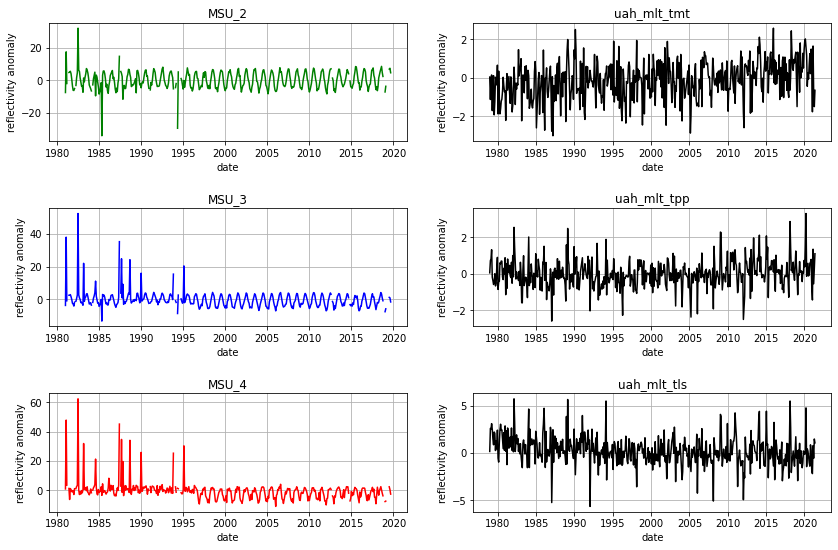

In [13]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(3,2)

ax[0,0].grid()
ax[0,0].set(xlabel='date', ylabel='reflectivity anomaly',
       title='MSU_2')
ax[0,0].plot(dates, a[:,0], color='green')

ax[0,1].grid()
ax[0,1].set(xlabel='date', ylabel='reflectivity anomaly',
       title='uah_mlt_tmt')
ax[0,1].plot(tmt.time, tmt.bt_anomaly_mt.values, color='black')


ax[1,0].grid()
ax[1,0].set(xlabel='date', ylabel='reflectivity anomaly',
       title='MSU_3')
ax[1,0].plot(dates, a[:,1], color='blue')

ax[1,1].grid()
ax[1,1].set(xlabel='date', ylabel='reflectivity anomaly',
       title='uah_mlt_tpp')
ax[1,1].plot(ttp.time, ttp.bt_anomaly_tp.values, color='black')


ax[2,0].grid()
ax[2,0].set(xlabel='date', ylabel='reflectivity anomaly',
       title='MSU_4')
ax[2,0].plot(dates, a[:,2], color='red')

ax[2,1].grid()
ax[2,1].set(xlabel='date', ylabel='reflectivity anomaly',
       title='uah_mlt_tls')
ax[2,1].plot(tls.time, tls.bt_anomaly_ls.values, color='black')


fig.tight_layout(pad=2.0)
plt.show()

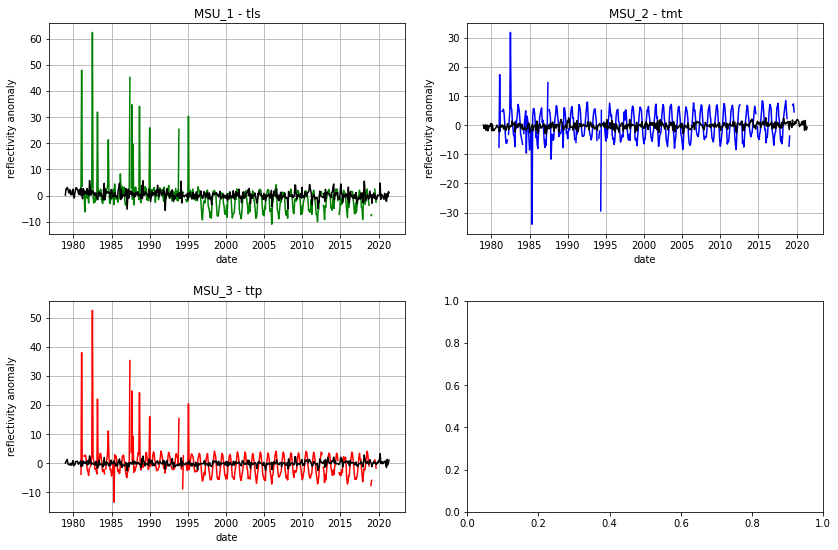

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(2,2)

ax[0,0].grid()
ax[0,0].set(xlabel='date', ylabel='reflectivity anomaly',
       title='MSU_1 - tls')
ax[0,0].plot(dates, a[:,2], color='green')
ax[0,0].plot(ch4.time, ch4.bt_anomaly_ls.values, color='black')

ax[0,1].grid()
ax[0,1].set(xlabel='date', ylabel='reflectivity anomaly',
       title='MSU_2 - tmt')
ax[0,1].plot(dates, a[:,0], color='blue')
ax[0,1].plot(ch2.time, ch2.bt_anomaly_mt.values, color='black')


ax[1,0].grid()
ax[1,0].set(xlabel='date', ylabel='reflectivity anomaly',
       title='MSU_3 - ttp')
ax[1,0].plot(dates, a[:,1], color='red')
ax[1,0].plot(ch3.time, ch3.bt_anomaly_tp.values, color='black')



fig.tight_layout(pad=2.0)
plt.show()

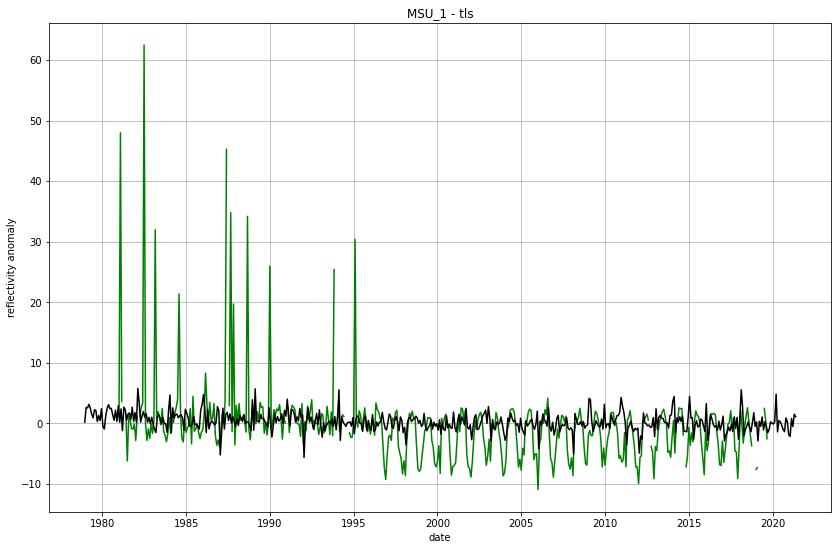

In [15]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()

ax.grid()
ax.set(xlabel='date', ylabel='reflectivity anomaly',
       title='MSU_1 - tls')
ax.plot(dates, a[:,2], color='green')
ax.plot(ch4.time, ch4.bt_anomaly_ls.values, color='black')

fig.tight_layout(pad=2.0)
plt.show()

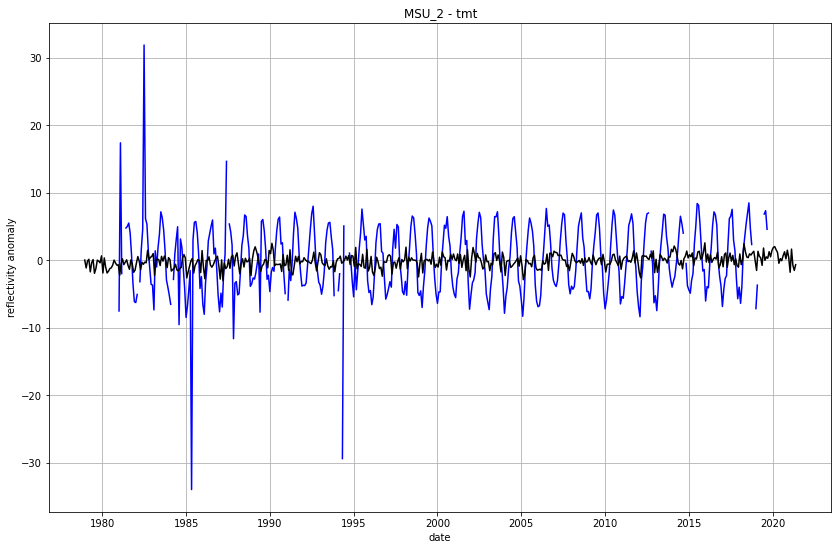

In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()

ax.grid()
ax.set(xlabel='date', ylabel='reflectivity anomaly',
       title='MSU_2 - tmt')
ax.plot(dates, a[:,0], color='blue')
ax.plot(ch2.time, ch2.bt_anomaly_mt.values, color='black')

fig.tight_layout(pad=2.0)
plt.show()

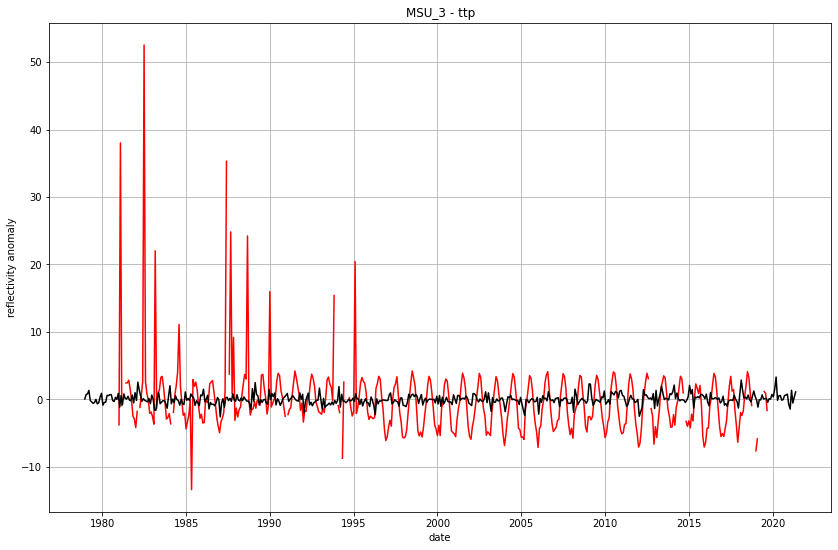

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()

ax.grid()
ax.set(xlabel='date', ylabel='reflectivity anomaly',
       title='MSU_3 - ttp')
ax.plot(dates, a[:,1], color='red')
ax.plot(ch3.time, ch3.bt_anomaly_tp.values, color='black')

fig.tight_layout(pad=2.0)
plt.show()

---

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import xarray

In [2]:
def compare_msu(re, ch, da, channel, rss_file, plot_color = 'blue',station_lat = 48.20, station_lon = 16.37, anomaly = False, anomaly_s = 1981, anomaly_e = 2011):
    
    dates = []
    for i in range(len(da)):
        dates.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

    rss = xarray.open_dataset(rss_file, decode_times=False)
    rss_vie = rss.sel(latitude = station_lat, longitude = station_lon, method='nearest')
    
#     yr = 1990
#     mon = 12
#     tmt = xarray.open_dataset('./uah_mlt_tmt_v06r00_monamg_s19781201_e20210630_c20210706.nc')
#     tmt = tmt.sel(lat = station_lat, lon = station_lon, method='nearest') 
#     ch2 = tmt

    time = pd.to_datetime('1978-1-1 0:0:0')
    rss_dates = []
    for i in rss_vie.months.values:
        rss_dates.append(time + pd.DateOffset(months=i))
    
    if anomaly:
        mean2 = 0
        mean3 = 0
        mean4 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        yrlist = [i for i in range(anomaly_s,anomaly_e + 1 )]
        for i in range(len(re)):
            if int(str(da[i])[:4]) in yrlist:
                if not isinstance(re[i], float):
                    if not np.isnan(re[i][0][0]):
                        mean2 += re[i][0][0]
                        count2 += 1
                    if not np.isnan(re[i][0][1]):
                        mean3 += re[i][0][1]
                        count3 += 1            
                    if not np.isnan(re[i][0][2]):
                        mean4 += re[i][0][2]
                        count4 += 1
        mean2 = mean2/count2
        mean3 = mean3/count3
        mean4 = mean4/count4

    for i in range(len(re)):
        if not isinstance(re[i], float):
            if not np.isnan(re[i][0][0]):
                if anomaly:
                    re[i][0][0] -= mean2
                    re[i][0][1] -= mean3
                    re[i][0][2] -= mean4
                else:
                    re[i][0][0] -= 0
                    re[i][0][1] -= 0
                    re[i][0][2] -= 0
        else:
            re[i] = [[np.nan, np.nan, np.nan]]

    a = np.resize(re,(len(re),3))

    plt.rcParams['figure.figsize'] = [12, 8]

    fig, ax = plt.subplots()

    ax.grid()
    if anomaly:
        ax.set(xlabel='date', ylabel='reflectivity anomaly [K]',
           title='Anomaly MSU_'+str(channel + 2))
    else:
        ax.set(xlabel='date', ylabel='reflectivity [K]',
           title='MSU_'+str(channel + 2))
    ax.plot(dates, a[:,channel], color=plot_color, label='MSU_'+str(channel + 2), linewidth=4, alpha=0.8)
    ax.plot(rss_dates, rss_vie.brightness_temperature.values, color='black', label='RSS')
    ax.legend()

    fig.tight_layout(pad=2.0)
    plt.show()
    plt.close()

### TLS - lower stratosphere - MSU 4
### TTS - troposphere stratosphere - MSU 3
### TMT - mid troposphere - MSU 2
### TTT - ?
### TLT - lower troposphere
### 

### Global monthly anomaly of atmosphere layer temperatures derived from microwave radiometers (MSU/AMSU) on NOAA and NASA polar orbiting satellites. The anomalies are deviations from 1981-2010 mean.

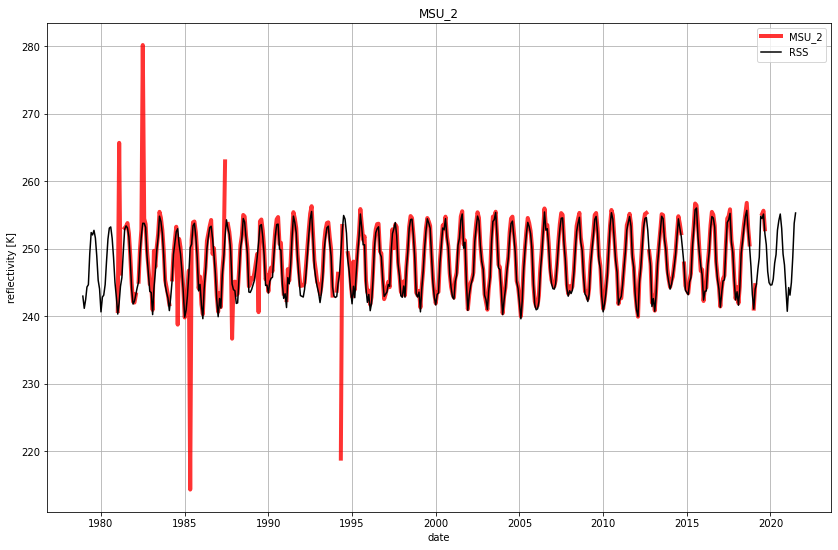

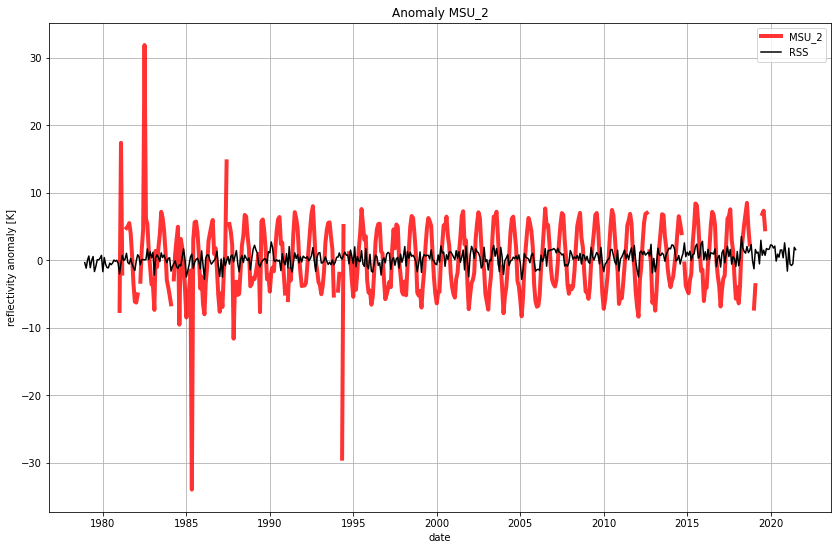

In [3]:
re = pickle.load( open( "./11035_refl.p", "rb" ) )
ch = pickle.load( open( "./11035_chan_list.p", "rb" ) )
da = pickle.load( open( "./11035_dates.p", "rb" ) )

compare_msu(re, ch, da, 0, './RSS_Tb_Maps_ch_TMT_V4_0.nc',plot_color='red', anomaly=False )
compare_msu(re, ch, da, 0, './RSS_Tb_Anom_Maps_ch_TMT_V4_0.nc',plot_color='red', anomaly=True )

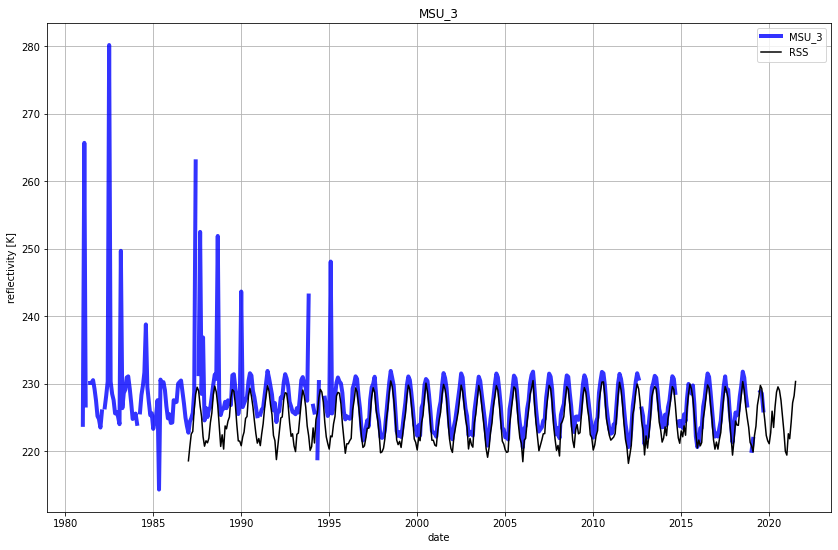

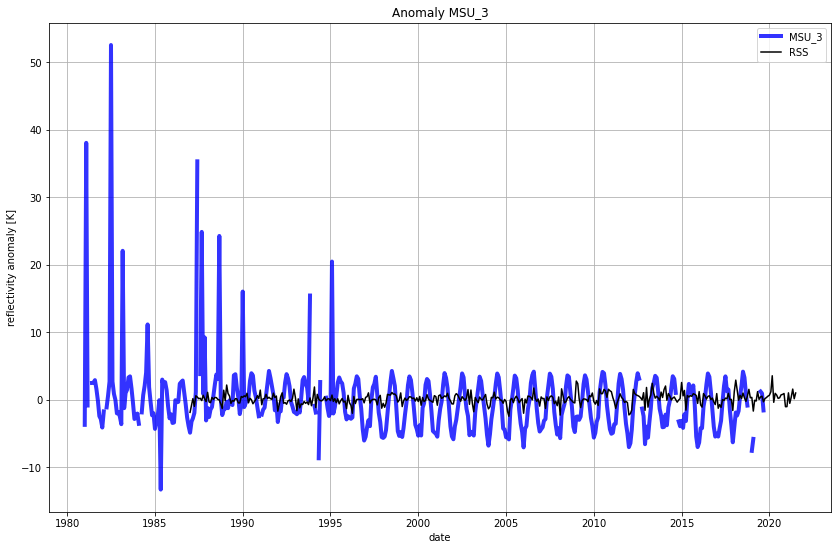

In [4]:
re = pickle.load( open( "./11035_refl.p", "rb" ) )
ch = pickle.load( open( "./11035_chan_list.p", "rb" ) )
da = pickle.load( open( "./11035_dates.p", "rb" ) )

compare_msu(re, ch, da, 1, './RSS_Tb_Maps_ch_TTS_V4_0.nc', anomaly=False )
compare_msu(re, ch, da, 1, './RSS_Tb_Anom_Maps_ch_TTS_V4_0.nc', anomaly=True )

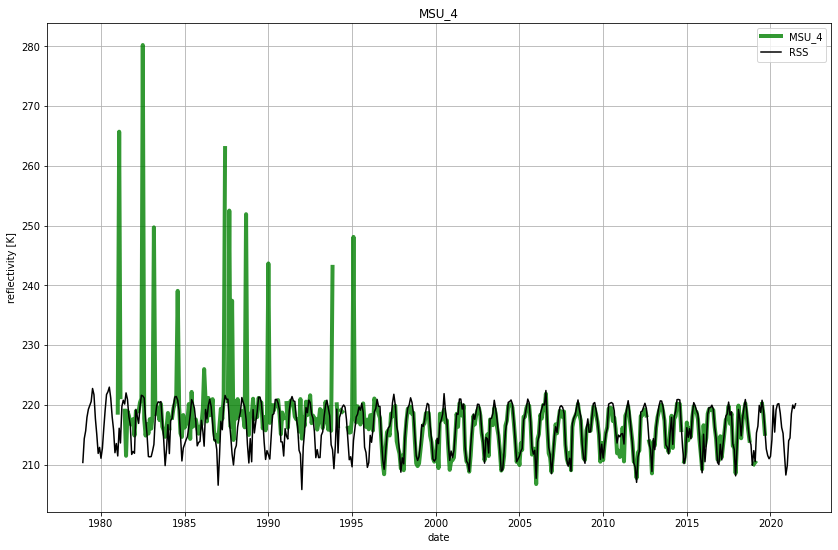

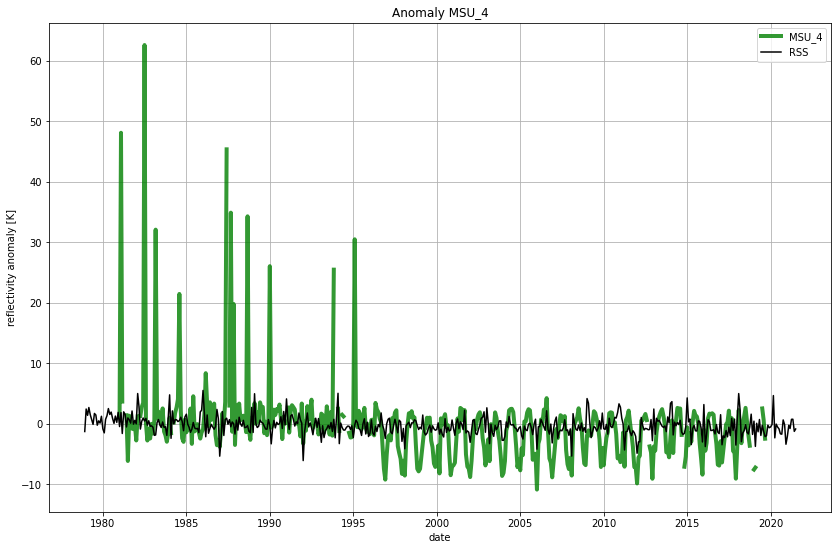

In [5]:
re = pickle.load( open( "./11035_refl.p", "rb" ) )
ch = pickle.load( open( "./11035_chan_list.p", "rb" ) )
da = pickle.load( open( "./11035_dates.p", "rb" ) )

compare_msu(re, ch, da, 2, './RSS_Tb_Maps_ch_TLS_V4_0.nc',plot_color='green', anomaly=False )
compare_msu(re, ch, da, 2, './RSS_Tb_Anom_Maps_ch_TLS_V4_0.nc',plot_color='green', anomaly=True )

In [6]:
rss = xarray.open_dataset('./RSS_Tb_Maps_ch_TLS_V4_0.nc', decode_times=False)
station_lat = 48.20
station_lon = 16.37
rss_vie = rss.sel(latitude = station_lat, longitude = station_lon, method='nearest')

In [7]:
rss = xarray.open_dataset('./RSS_Tb_Anom_Maps_ch_TLS_V4_0.nc', decode_times=False)
station_lat = 48.20
station_lon = 16.37
rss_anomaly_vie = rss.sel(latitude = station_lat, longitude = station_lon, method='nearest')

In [8]:
time = pd.to_datetime('1978-1-1 0:0:0')
rss_dates = []
for i in rss_vie.months.values:
    rss_dates.append(time + pd.DateOffset(months=i))

In [9]:
yrlist = [i for i in range(1978,2010 + 1 )]
mean = 0
count = 0
for i in range(len(rss_vie.brightness_temperature.values)):
    if rss_dates[i].year in yrlist:
        if not np.isnan(rss_vie.brightness_temperature.values[i]):
            mean += (rss_vie.brightness_temperature.values[i])
            count += 1
manually_anomaly = rss_vie.brightness_temperature.values - (mean/count)
# manually_anomaly

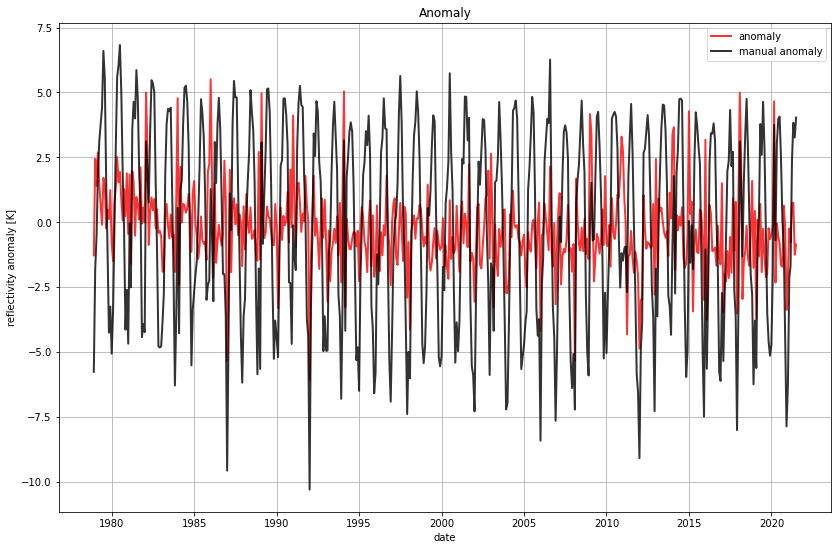

In [11]:
fig, ax = plt.subplots()

ax.grid()
ax.set(xlabel='date', ylabel='reflectivity anomaly [K]', title='Anomaly')
ax.plot(rss_dates, rss_anomaly_vie.brightness_temperature.values, color='red', label='anomaly', linewidth=2, alpha=0.8)
ax.plot(rss_dates, manually_anomaly, color='black', label='manual anomaly',linewidth=2, alpha=0.8)
ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()